In [29]:
import torch
from torch import nn
import numpy as np
from scipy.stats import pearsonr, f_oneway
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from matplotlib_venn import venn3_unweighted

# PCA on Expression Matrix

Here, we will run Principal Component Analysis on our CRC Expression Matrix to see how well the samples cluster with each other. If we identify samples that cluster separately, that can tell us whether to include them in training the Enformer model. 

In [2]:
# Load gene counts and metadata in
gene_counts = pd.read_csv('/pollard/home/aravi1/CRC_TCGA_HCMI_data/crc_gene_counts.tsv', sep='\t')
metadata = pd.read_csv('/pollard/home/aravi1/CRC_TCGA_HCMI_data/crc_metadata.tsv', sep='\t')

# Rename count columns to each biosample ID 
biosample_id = metadata['File.Name'].str.split('.').str[0]
gene_counts.columns.values[3:] = biosample_id 

In this case, we are running PCA on the raw TPM counts from all of the CRC-related cohorts. 

In [3]:
metadata['id'] = biosample_id

In [4]:
pca = PCA(n_components=5)
pca.fit(gene_counts.iloc[:,3:])

explained_variance = pca.explained_variance_ratio_
total_explained_variance = explained_variance.sum()

In [5]:
PCA_df = pd.DataFrame(data=pca.components_.reshape(5,833).T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

PCA_df['id'] = gene_counts.columns[3:]
PCA_df = pd.merge(PCA_df, metadata, on="id", how="inner")

In [6]:
explained_variance

array([0.69045969, 0.24278145, 0.01621589, 0.01000893, 0.00727172])

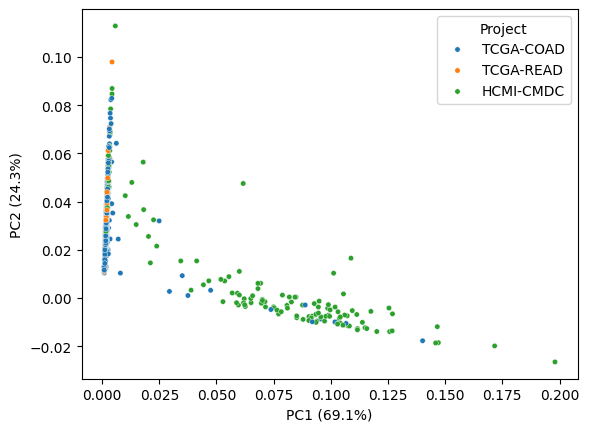

In [7]:
sns.scatterplot(x='PC1', y='PC2', hue='Project', data=PCA_df, s=15) 
plt.xlabel("PC1 (69.1%)")
plt.ylabel("PC2 (24.3%)")
plt.show()

As we can see from above, the HCMI-CMDC cohort samples seem to cluster away from the TCGA cohorts, both COAD as well as READ. This may be due to a variety of factors, such as the fact that HCMI-CMDC samples are mostly organoid/cell line-derived samples, whereas TCGA samples consist of actual tumor samples. In addition, the sequencing depth for cohorts may differ greatly. 

**What if we normalize our raw count matrix and rerun PCA?**

In [9]:
pca = PCA(n_components=5)
pca.fit(np.log(gene_counts.iloc[:,3:] + 0.00001))

explained_variance = pca.explained_variance_ratio_
total_explained_variance = explained_variance.sum()

PCA_df = pd.DataFrame(data=pca.components_.reshape(5,833).T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

PCA_df['id'] = gene_counts.columns[3:]
PCA_df = pd.merge(PCA_df, metadata, on="id", how="inner")

print(explained_variance)

[0.77676171 0.02744324 0.00894437 0.00593599 0.00285908]


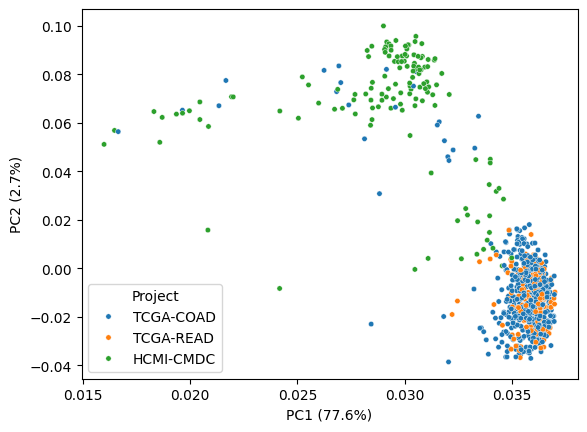

In [10]:
sns.scatterplot(x='PC1', y='PC2', hue='Project', data=PCA_df, s=15) 
plt.xlabel("PC1 (77.6%)")
plt.ylabel("PC2 (2.7%)")
plt.show()

After normalization and clustering, we observe that cohorts seem to separate from each other. Specifically, HCMI-CMDC clusters away from the TCGA samples. 

### How do CRC-relevant genes differ in expression across each cohort?

Next, let's see how the functionally-relevant genes differ in expression as each cohort, as these will likely be the most important genes/features in the fine-tuning process. 

Text(0.5, 0, 'CRC-relevant Genes')

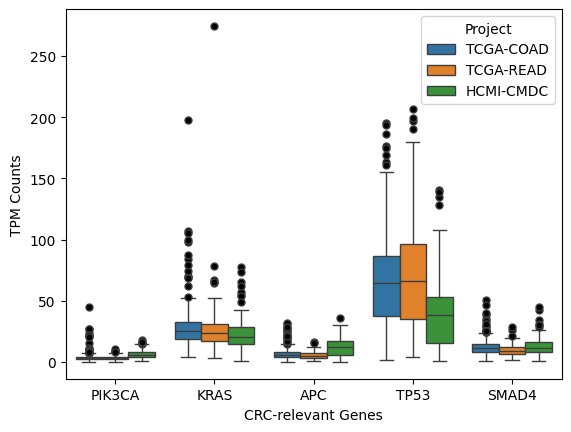

In [11]:
CRC_genes = ['APC', 'TP53', 'KRAS', 'PIK3CA', 'SMAD4']
CRC_counts = gene_counts[gene_counts['gene_name'].isin(CRC_genes)]

CRC_counts = CRC_counts.iloc[:,3:].T
CRC_counts.columns = ['PIK3CA', 'KRAS', 'APC', 'TP53', 'SMAD4']
CRC_counts['id'] = gene_counts.columns[3:]

CRC_counts = pd.merge(CRC_counts, metadata, on='id', how="inner")

dd=pd.melt(CRC_counts, id_vars=['Project'], value_vars=['PIK3CA', 'KRAS', 'APC', 'TP53', 'SMAD4'])

ax = sns.boxplot(x='variable',y='value', data=dd, hue='Project', flierprops={'marker': '.', 'markersize': 10, 'markerfacecolor': 'black'})
ax.set_ylabel("TPM Counts")
ax.set_xlabel("CRC-relevant Genes")

We do see slight differences in expression counts in HCMI-CMDC vs. the TCGA cohorts. Let's see whether these differences persist across all genes by doing an ANOVA test to identify genes that differ in their mean expression across each cohort.  

In [22]:
anova_gene_counts = np.log(gene_counts.iloc[:,3:] + 1).T
anova_gene_counts['id'] = anova_gene_counts.index

anova_gene_counts = pd.merge(anova_gene_counts, metadata, on='id', how='inner')


tcga_coad = anova_gene_counts.iloc[:, 0:60661][anova_gene_counts['Project'] == 'TCGA-COAD']
tcga_read = anova_gene_counts.iloc[:, 0:60661][anova_gene_counts['Project'] == 'TCGA-READ']
hcmi_cmdc = anova_gene_counts.iloc[:, 0:60661][anova_gene_counts['Project'] == 'HCMI-CMDC']

coad_vs_read = []
coad_vs_hcmi = []
read_vs_hcmi = []

for i in range(0, 60660, 1):
    coad_vs_read_p = f_oneway(tcga_coad.iloc[:, i], tcga_read.iloc[:, i])[1]
    coad_vs_hcmi_p = f_oneway(tcga_coad.iloc[:, i], hcmi_cmdc.iloc[:, i])[1]
    read_vs_hcmi_p = f_oneway(tcga_read.iloc[:, i], hcmi_cmdc.iloc[:, i])[1]
    
    coad_vs_read.append(coad_vs_read_p)
    coad_vs_hcmi.append(coad_vs_hcmi_p)
    read_vs_hcmi.append(read_vs_hcmi_p)
    
    if (i % 20000 == 0):
        print(i)
    
    if (i == 60659):
        break

0


/pollard/home/aravi1/miniconda3/envs/enformer-pytorch/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


20000
40000
60000


Text(0.5, 0.98, 'Histogram of p-values for Difference in Gene Count Means')

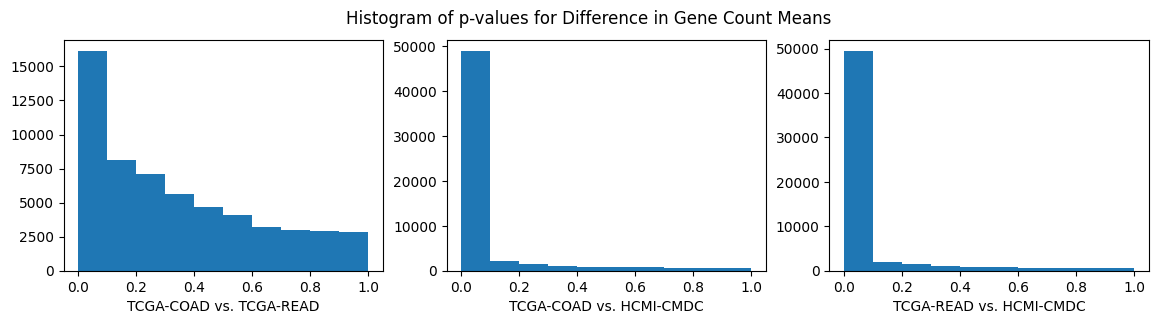

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 3))

ax[0].hist(coad_vs_read)
ax[0].set_xlabel('TCGA-COAD vs. TCGA-READ')

ax[1].hist(coad_vs_hcmi)
ax[1].set_xlabel('TCGA-COAD vs. HCMI-CMDC')
    
ax[2].hist(read_vs_hcmi)
ax[2].set_xlabel('TCGA-READ vs. HCMI-CMDC')

fig.suptitle("Histogram of p-values for Difference in Gene Count Means")

In [27]:
# Doing Bonferroni Correction to ANOVA-tested genes, divide by number of tests (genes in this case)

print("Number of TCGA-COAD vs. TCGA-READ different genes: ", np.sum(np.array(coad_vs_read) < (0.05 / 60660)))
print("Number of TCGA-COAD vs. HCMI different genes: ", np.sum(np.array(coad_vs_hcmi) < (0.05 / 60660)))
print("Number of TCGA-READ vs. HCMI different genes: ", np.sum(np.array(read_vs_hcmi) < (0.05 / 60660)))

After multiple hypothesis testing, we identify:
Number of TCGA-COAD vs. TCGA-READ different genes:  74
Number of TCGA-COAD vs. HCMI different genes:  27977
Number of TCGA-READ vs. HCMI different genes:  25740


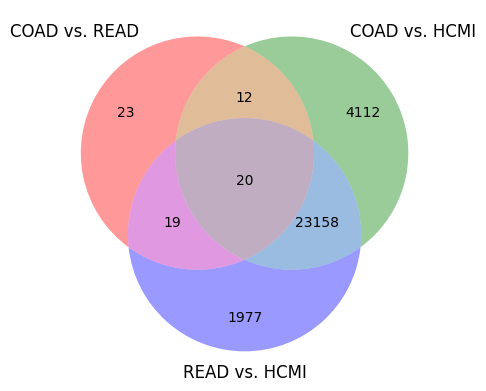

In [30]:
gene_significances = pd.concat([pd.Series(coad_vs_read), pd.Series(coad_vs_hcmi), pd.Series(read_vs_hcmi)], axis=1)
gene_significances['gene'] = gene_counts['gene_name']
gene_significances = gene_significances[pd.isna(gene_significances[0]) == False]
gene_significances.columns = ['coad_vs_read', 'coad_vs_hcmi', 'read_vs_hcmi', 'gene']

coad_vs_read_sig = set(gene_significances['gene'][gene_significances['coad_vs_read'] < (0.05 / 60660)])
coad_vs_hcmi_sig = set(gene_significances['gene'][gene_significances['coad_vs_hcmi'] < (0.05 / 60660)])
read_vs_hcmi_sig = set(gene_significances['gene'][gene_significances['read_vs_hcmi'] < (0.05 / 60660)])

set_array = []
set_array.append(coad_vs_read_sig)
set_array.append(coad_vs_hcmi_sig)
set_array.append(read_vs_hcmi_sig)

venn3_unweighted(set_array[0:3], ['COAD vs. READ', 'COAD vs. HCMI', 'READ vs. HCMI'])   # venn3 works for three sets
plt.show()

50% of genes in HCMI-CMDC have significant difference in means compared to TCGA-COAD/READ (ANOVA test). Because the HCMI cohort seems to cluster slightly differently compared to the TCGA samples, this might disrupt using the median TPM count across cohorts as our target variable. 

**CONSENSUS**: Instead, we will fine-tune Enformer using only the TCGA samples and calcuate the median across TCGA cohorts. This way, we can see how well our model generalizes to the HCMI cohort.